In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd

gppd.set_interactive()
pd.set_option('display.max_colwidth',1000)

In [2]:
env = gp.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-03


## Data

In [3]:
import os

data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "artifacts", "input_data.xlsx")
waste_source_data = pd.read_excel(data_path, sheet_name='Waste Source')
shredder_data = pd.read_excel(data_path, sheet_name='E-waste Collector')
oxide_producer_data = pd.read_excel(data_path, sheet_name='Oxide Producer')
fluoride_producer_data = pd.read_excel(data_path, sheet_name='Flouride Producer')
metal_producer_data = pd.read_excel(data_path, sheet_name='Metal Producer')
magnet_producer_data = pd.read_excel(data_path, sheet_name='Magnet Producer')

# Create dictionaries for shredder and oxide producer coordinates
waste_source = {row['Code']: (row['Latitude'], row['Longitude']) for index, row in waste_source_data.iterrows()}
shredders = {row['Code']: (row['Latitude'], row['Longitude']) for index, row in shredder_data.iterrows()}
oxide_producers = {row['Code']: (row['Latitude'], row['Longitude']) for index, row in oxide_producer_data.iterrows()}
fluoride_producers = {row['Code']: (row['Latitude'], row['Longitude']) for index, row in fluoride_producer_data.iterrows()}
metal_producers = {row['Code']: (row['Latitude'], row['Longitude']) for index, row in metal_producer_data.iterrows()}
magnet_producers = {row['Code']: (row['Latitude'], row['Longitude']) for index, row in magnet_producer_data.iterrows()}

In [4]:

price = pd.read_excel(data_path, sheet_name='REE Price')
price.set_index("Year", inplace = True)
price = price["Price"]
price.index.name = "year"
price

year
Y1     122000.000000
Y2     126001.600000
Y3     130134.452480
Y4     134402.862521
Y5     138811.276412
Y6     143364.286278
Y7     148066.634868
Y8     152923.220492
Y9     157939.102124
Y10    163119.504674
Name: Price, dtype: float64

In [5]:
MARR = 0.08

In [6]:
waste_volume = pd.read_excel(data_path, sheet_name='Waste Volume')
waste_volume.set_index('Code', inplace=True)
waste_volume = waste_volume['volume (ton)']
waste_volume.index.name = "from"
waste_volume.head()

from
W1    8258.035
W2    3820.914
W3    2664.452
W4    2314.157
W5    1650.070
Name: volume (ton), dtype: float64

In [7]:
oc_shredder = pd.read_excel(data_path, sheet_name='Shredder_OC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
oc_shredder = pd.melt(oc_shredder, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="shredder_oc")
oc_shredder.set_index(["Code", "Year"], inplace=True)
oc_shredder = oc_shredder["shredder_oc"]
oc_shredder.index.names = ["from", "year"]
oc_shredder.head()

from  year
S01   Y1      3611.000000
S02   Y1      3933.086683
S03   Y1      4128.153266
S04   Y1      2912.389447
S05   Y1      4128.153266
Name: shredder_oc, dtype: float64

In [8]:
oc_oxide = pd.read_excel(data_path, sheet_name='Oxide_OC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
oc_oxide = pd.melt(oc_oxide, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="oxide_oc")
oc_oxide.set_index(["Code", "Year"], inplace=True)
oc_oxide = oc_oxide["oxide_oc"]
oc_oxide.index.names = ["from", "year"]
oc_oxide.head()

from  year
OP01  Y1      7789.251256
OP02  Y1      7702.428392
OP03  Y1      8806.319095
OP04  Y1      7702.428392
OP05  Y1      7255.910804
Name: oxide_oc, dtype: float64

In [9]:
oc_fluoride = pd.read_excel(data_path, sheet_name='Fluoride_OC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
oc_fluoride = pd.melt(oc_fluoride, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="fluoride_oc")
oc_fluoride.set_index(["Code", "Year"], inplace=True)
oc_fluoride = oc_fluoride['fluoride_oc']
oc_fluoride.index.names = ["from", "year"]
oc_fluoride.head()

from  year
FP01  Y1      13000.000000
FP02  Y1      13395.818048
FP03  Y1      13395.818048
FP04  Y1      13047.688921
FP05  Y1      13722.487161
Name: fluoride_oc, dtype: float64

In [10]:
oc_ree = pd.read_excel(data_path, sheet_name='REE_OC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
oc_ree = pd.melt(oc_ree, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="ree_oc")
oc_ree.set_index(["Code", "Year"], inplace=True)
oc_ree = oc_ree['ree_oc']
oc_ree.index.names = ["from", "year"]
oc_ree.head()

from  year
MP01  Y1       72899.000000
MP02  Y1      194427.860553
MP03  Y1       56872.209799
MP01  Y2       75290.087200
MP02  Y2      200805.094379
Name: ree_oc, dtype: float64

In [11]:
fc_shredder = pd.read_excel(data_path, sheet_name='Shredder_FC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
fc_shredder = pd.melt(fc_shredder, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="shredder_fc")
fc_shredder.set_index(["Code", "Year"], inplace=True)
fc_shredder = fc_shredder['shredder_fc']
fc_shredder.index.names = ["from", "year"]
fc_shredder.head()

from  year
S01   Y1      0
S02   Y1      0
S03   Y1      0
S04   Y1      0
S05   Y1      0
Name: shredder_fc, dtype: int64

In [12]:
fc_oxide = pd.read_excel(data_path, sheet_name='Oxide_FC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
fc_oxide = pd.melt(fc_oxide, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="oxide_fc")
fc_oxide.set_index(["Code", "Year"], inplace=True)
fc_oxide = fc_oxide['oxide_fc']
fc_oxide.index.names = ["from", "year"]
fc_oxide.head()

from  year
OP01  Y1      134382.719638
OP02  Y1      142479.940288
OP03  Y1      147852.134758
OP04  Y1      140027.416726
OP05  Y1      139365.624654
Name: oxide_fc, dtype: float64

In [13]:
fc_fluoride = pd.read_excel(data_path, sheet_name='Fluoride_FC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
fc_fluoride = pd.melt(fc_fluoride, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="fluoride_fc")
fc_fluoride.set_index(["Code", "Year"], inplace=True)
fc_fluoride = fc_fluoride['fluoride_fc']
fc_fluoride.index.names = ["from", "year"]
fc_fluoride.head()

from  year
FP01  Y1      0
FP02  Y1      0
FP03  Y1      0
FP04  Y1      0
FP05  Y1      0
Name: fluoride_fc, dtype: int64

In [14]:
fc_ree = pd.read_excel(data_path, sheet_name='REE_FC')
year_index = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10"]
fc_ree = pd.melt(fc_ree, id_vars=["Code"], value_vars=year_index, var_name="Year", value_name="ree_fc")
fc_ree.set_index(["Code", "Year"], inplace=True)
fc_ree= fc_ree['ree_fc']
fc_ree.index.names = ["from", "year"]
fc_ree.head()

from  year
MP01  Y1      0
MP02  Y1      0
MP03  Y1      0
MP01  Y2      0
MP02  Y2      0
Name: ree_fc, dtype: int64

In [15]:
conv1 = 0.089 # conversion factor from shredded HDD to initial oxalate
conv2 = 0.083 # conversion factor from oxalate to oxides
conv3 = 1.074 # conversion fcator from oxides to fluorides
conv4 = 0.72 # conversion factor from fluorides to metals
w = 0.3 # Tax credit as percentage of capital cost

In [16]:
inflation_rate = 0.0328

In [17]:
shredder_cap = pd.read_excel(data_path, sheet_name='Shredder Capacity')
oxide_cap = pd.read_excel(data_path, sheet_name='Oxide Capacity')
fluoride_cap = pd.read_excel(data_path, sheet_name='Fluoride Capacity')
metal_cap = pd.read_excel(data_path, sheet_name='REE Capacity')

In [18]:
shredder_cap.set_index("Code", inplace=True)
shredder_cap = shredder_cap['Capacity']
shredder_cap.index.name = "from"
shredder_cap

from
S01      648.000000
S02       21.277877
S03     4610.206595
S04     7979.203721
S05     8865.781913
           ...     
S654     648.000000
S655     648.000000
S656     648.000000
S657     648.000000
S658     648.000000
Name: Capacity, Length: 658, dtype: float64

In [19]:
'''
shredder_cap_copy = pd.read_excel(data_path, sheet_name='Shredder Capacity')
shredder_cap_copy.set_index("Code", inplace=True)
shredder_cap_copy = shredder_cap_copy['Capacity']
shredder_cap_copy.index.name = "to"
shredder_cap_copy
'''

'\nshredder_cap_copy = pd.read_excel(data_path, sheet_name=\'Shredder Capacity\')\nshredder_cap_copy.set_index("Code", inplace=True)\nshredder_cap_copy = shredder_cap_copy[\'Capacity\']\nshredder_cap_copy.index.name = "to"\nshredder_cap_copy\n'

In [20]:
oxide_cap.set_index("Code", inplace=True)
oxide_cap = oxide_cap['Capacity']
oxide_cap.index.name = "from"
oxide_cap

from
OP01    54
OP02    54
OP03    54
OP04    54
OP05    54
        ..
OP61    54
OP62    54
OP63    54
OP64    54
OP65    54
Name: Capacity, Length: 65, dtype: int64

In [21]:
fluoride_cap.set_index("Code", inplace=True)
fluoride_cap = fluoride_cap['Capacity']
fluoride_cap.index.name = "from"
fluoride_cap

from
FP01    58
FP02    58
FP03    58
FP04    58
FP05    58
FP06    58
Name: Capacity, dtype: int64

In [22]:
metal_cap.set_index("Code", inplace=True)
metal_cap = metal_cap['Capacity']
metal_cap.index.name = "from"
metal_cap

from
MP01      41
MP02     150
MP03    1000
Name: Capacity, dtype: int64

In [23]:
shredder_to_oxide_tc = pd.read_excel(data_path, sheet_name='Shredder-Oxide TC')
shredder_to_oxide_tc.head()

,index,OP01,OP02,OP03,OP04,OP05,OP06,OP07,OP08,OP09,...,OP56,OP57,OP58,OP59,OP60,OP61,OP62,OP63,OP64,OP65
0,S01,334.407348,488.348682,564.060175,485.621957,90.927425,183.035852,275.984457,270.420928,277.394211,...,374.883217,1.098491,17.322992,57.706791,531.452322,79.657983,696.861825,264.607448,159.607079,156.414433
1,S02,329.271919,501.179926,579.118630,498.013921,74.482482,183.409096,273.018561,267.698212,274.655395,...,375.247801,21.249216,17.778701,73.857514,548.587929,98.201676,708.259641,267.194946,142.142945,172.878489
2,S03,329.528755,484.346550,560.552164,481.538696,88.137240,177.980781,270.998559,265.426105,272.399187,...,369.826365,3.995813,13.493944,54.236763,528.557834,82.448202,692.624648,269.651482,162.253392,153.220321
3,S04,341.867587,619.530380,708.982162,613.881510,121.805879,258.872542,309.576508,306.807535,312.495259,...,422.145286,181.878228,172.800296,227.173964,690.522340,251.509475,813.836572,325.497049,86.897086,319.839663
4,S05,261.348719,417.930153,500.711482,414.022882,92.080114,103.153579,199.567647,193.667781,200.576604,...,293.797556,81.191842,70.811249,49.120494,477.815578,135.130902,622.594985,345.281700,221.330893,108.960581


In [24]:
column_names = shredder_to_oxide_tc.columns.delete(0)
shredder_to_oxide_tc = pd.melt(shredder_to_oxide_tc, id_vars=["index"], value_vars=column_names, var_name="to", value_name="Y1").rename({'index':'from'}, axis = 1)

for i in range(2, 11):
    var_name = "Y" + str(i)
    shredder_to_oxide_tc[var_name] = shredder_to_oxide_tc.iloc[:, i] * (1 + inflation_rate)

shredder_to_oxide_tc.head()

,from,to,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
0,S01,OP01,334.407348,345.375909,356.704239,368.404138,380.487794,392.967793,405.857137,419.169251,432.918002,447.117713
1,S02,OP01,329.271919,340.072038,351.226401,362.746627,374.644717,386.933063,399.624468,412.732150,426.269765,440.251413
2,S03,OP01,329.528755,340.337298,351.500362,363.029573,374.936943,387.234875,399.936179,413.054086,426.602260,440.594814
3,S04,OP01,341.867587,353.080843,364.661895,376.622805,388.976033,401.734447,414.911337,428.520429,442.575899,457.092388
4,S05,OP01,261.348719,269.920957,278.774364,287.918164,297.361879,307.115349,317.188732,327.592523,338.337558,349.435029


In [25]:
shredder_to_oxide_tc = pd.melt(shredder_to_oxide_tc, id_vars=["from", "to"], value_vars=year_index, var_name="year", value_name="cost")
shredder_to_oxide_tc.set_index(["from", "to", "year"], inplace=True)

In [26]:
shredder_to_oxide_tc = shredder_to_oxide_tc["cost"]
shredder_to_oxide_tc.head()

from  to    year
S01   OP01  Y1      334.407348
S02   OP01  Y1      329.271919
S03   OP01  Y1      329.528755
S04   OP01  Y1      341.867587
S05   OP01  Y1      261.348719
Name: cost, dtype: float64

In [27]:
oxide_to_fluoride_tc = pd.read_excel(data_path, sheet_name='Oxide-Fluoride TC')

column_names = oxide_to_fluoride_tc.columns.delete(0)
oxide_to_fluoride_tc = pd.melt(oxide_to_fluoride_tc, id_vars=["index"], value_vars=column_names, var_name="to", value_name="Y1").rename({'index':'from'}, axis = 1)

for i in range(2, 11):
    var_name = "Y" + str(i)
    oxide_to_fluoride_tc[var_name] = oxide_to_fluoride_tc.iloc[:, i] * (1 + inflation_rate)

oxide_to_fluoride_tc.head()

oxide_to_fluoride_tc = pd.melt(oxide_to_fluoride_tc, id_vars=["from", "to"], value_vars=year_index, var_name="year", value_name="cost")
oxide_to_fluoride_tc.set_index(["from", "to", "year"], inplace=True)

In [28]:
oxide_to_fluoride_tc = oxide_to_fluoride_tc['cost']
oxide_to_fluoride_tc.head()

from  to    year
OP01  FP01  Y1      498.508979
OP02  FP01  Y1      624.991040
OP03  FP01  Y1      731.486025
OP04  FP01  Y1      630.205799
OP05  FP01  Y1      190.370462
Name: cost, dtype: float64

In [29]:
waste_to_shredder_tc = pd.read_excel(data_path, sheet_name='Waste-Shredder TC')

column_names = waste_to_shredder_tc.columns.delete(0)
waste_to_shredder_tc = pd.melt(waste_to_shredder_tc, id_vars=["index"], value_vars=column_names, var_name="to", value_name="Y1").rename({'index':'from'}, axis = 1)

for i in range(2, 11):
    var_name = "Y" + str(i)
    waste_to_shredder_tc[var_name] = waste_to_shredder_tc.iloc[:, i] * (1 + inflation_rate)

waste_to_shredder_tc.head()

waste_to_shredder_tc = pd.melt(waste_to_shredder_tc, id_vars=["from", "to"], value_vars=year_index, var_name="year", value_name="cost")
waste_to_shredder_tc.set_index(["from", "to", "year"], inplace=True)

In [30]:
waste_to_shredder_tc = waste_to_shredder_tc['cost']
waste_to_shredder_tc.head()

from  to   year
W1    S01  Y1      230.710432
W2    S01  Y1      651.299245
W3    S01  Y1       59.633613
W4    S01  Y1      312.664866
W5    S01  Y1      539.862646
Name: cost, dtype: float64

In [31]:
fluoride_to_metal_tc = pd.read_excel(data_path, sheet_name='Fluoride-Metal TC')
fluoride_to_metal_tc.head()

column_names = fluoride_to_metal_tc.columns.delete(0)
fluoride_to_metal_tc = pd.melt(fluoride_to_metal_tc, id_vars=["index"], value_vars=column_names, var_name="to", value_name="Y1").rename({'index':'from'}, axis = 1)

for i in range(2, 11):
    var_name = "Y" + str(i)
    fluoride_to_metal_tc[var_name] = fluoride_to_metal_tc.iloc[:, i] * (1 + inflation_rate)

fluoride_to_metal_tc.head()

fluoride_to_metal_tc = pd.melt(fluoride_to_metal_tc, id_vars=["from", "to"], value_vars=year_index, var_name="year", value_name="cost")
fluoride_to_metal_tc.set_index(["from", "to", "year"], inplace=True)


In [32]:
fluoride_to_metal_tc = fluoride_to_metal_tc['cost']
fluoride_to_metal_tc.head()

from  to    year
FP01  MP01  Y1        1.466763
FP02  MP01  Y1      848.229560
FP03  MP01  Y1      847.836082
FP04  MP01  Y1      346.382616
FP05  MP01  Y1      223.095803
Name: cost, dtype: float64

In [33]:
metal_to_magnet_tc = pd.read_excel(data_path, sheet_name='Metal-Magnet TC')
metal_to_magnet_tc.head()

column_names = metal_to_magnet_tc.columns.delete(0)
metal_to_magnet_tc = pd.melt(metal_to_magnet_tc, id_vars=["index"], value_vars=column_names, var_name="to", value_name="Y1").rename({'index':'from'}, axis = 1)

for i in range(2, 11):
    var_name = "Y" + str(i)
    metal_to_magnet_tc[var_name] = metal_to_magnet_tc.iloc[:, i] * (1 + inflation_rate)

metal_to_magnet_tc.head()

metal_to_magnet_tc = pd.melt(metal_to_magnet_tc, id_vars=["from", "to"], value_vars=year_index, var_name="year", value_name="cost")
metal_to_magnet_tc.set_index(["from", "to", "year"], inplace=True)

In [34]:
metal_to_magnet_tc = metal_to_magnet_tc['cost']
metal_to_magnet_tc.head()

from  to     year
MP01  MAG01  Y1      370.090621
MP02  MAG01  Y1      433.013111
MP03  MAG01  Y1      232.435930
MP01  MAG02  Y1      512.362583
MP02  MAG02  Y1      480.118856
Name: cost, dtype: float64

In [35]:
is_shredder_incentive_eligible = shredder_data[["Code", "is_energy_community"]]
is_oxide_producer_incentive_eligible = oxide_producer_data[["Code", "is_energy_community"]]

is_shredder_incentive_eligible.set_index("Code", inplace = True)
is_oxide_producer_incentive_eligible.set_index("Code", inplace = True)

is_shredder_incentive_eligible.index.name = "from"
is_oxide_producer_incentive_eligible.index.name = "from"

is_shredder_incentive_eligible = is_shredder_incentive_eligible["is_energy_community"]
is_oxide_producer_incentive_eligible = is_oxide_producer_incentive_eligible["is_energy_community"]

In [36]:
is_shredder_incentive_eligible[:5]

from
S01    1
S02    0
S03    1
S04    1
S05    1
Name: is_energy_community, dtype: int64

## Model with no fixed charge

In [37]:
model_no_fixed_charge = gp.Model("Ewaste_no_fixed_charge", env=env)
model_no_fixed_charge.ModelSense = GRB.MAXIMIZE

## Decision Variables

In [38]:

flow_shredder_to_oxide = gppd.add_vars(
    model_no_fixed_charge,
    shredder_to_oxide_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_shredder_to_oxide"
)

flow_oxide_to_fluoride = gppd.add_vars(
    model_no_fixed_charge,
    oxide_to_fluoride_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_oxide_to_fluoride"
)

flow_fluoride_to_metal = gppd.add_vars(
    model_no_fixed_charge,
    fluoride_to_metal_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_fluoride_to_metal"
)

shredder_loc = list(shredders.keys())
waste_to_shredder_index = pd.MultiIndex.from_product([waste_volume.index, shredder_loc, year_index], names = ["from", "to", "year"])
flow_waste_to_shredder = gppd.add_vars(
    model_no_fixed_charge,
    waste_to_shredder_index,
    vtype = GRB.CONTINUOUS,
    name = "flow_waste_to_shredder"
)

flow_metal_to_magnet = gppd.add_vars(
    model_no_fixed_charge,
    metal_to_magnet_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_metal_to_magnet"
)

## Constraints

### Flow balance constraints

In [39]:
shredder_balance = gppd.add_constrs(
    model_no_fixed_charge,
    flow_shredder_to_oxide.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv1 * (flow_waste_to_shredder.groupby(['to', 'year']).sum()),
    name = "shredder_balance"
)

In [40]:
oxide_balance = gppd.add_constrs(
    model_no_fixed_charge,
    flow_oxide_to_fluoride.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv2 * (flow_shredder_to_oxide.groupby(['to', 'year']).sum()),
    name = "oxide_balance"
)

In [41]:
fluoride_balance = gppd.add_constrs(
    model_no_fixed_charge,
    flow_fluoride_to_metal.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv3 * (flow_oxide_to_fluoride.groupby(['to', 'year']).sum()),
    name = "fluoride_balance"
)

In [42]:
metal_balance = gppd.add_constrs(
    model_no_fixed_charge,
    flow_metal_to_magnet.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv4 * (flow_fluoride_to_metal.groupby(['to', 'year']).sum()),
    name = "metal_balance"
)

### Capacity constraint

In [43]:
waste_supply_limit = gppd.add_constrs(
    model_no_fixed_charge,
    flow_waste_to_shredder.groupby(['from', 'year']).sum() - waste_volume,
    GRB.LESS_EQUAL,
    0,
    name = "waste_supply_limit"
)

In [44]:
shredder_supply_limit = gppd.add_constrs(
    model_no_fixed_charge,
    flow_shredder_to_oxide.groupby(['from', 'year']).sum() - shredder_cap,
    GRB.LESS_EQUAL,
    0,
    name = "shredder_supply_limit"
)

In [45]:
oxide_supply_limit = gppd.add_constrs(
    model_no_fixed_charge,
    flow_oxide_to_fluoride.groupby(['from', 'year']).sum() - oxide_cap,
    GRB.LESS_EQUAL,
    0,
    name = "oxide_supply_limit"
)

In [46]:
fluoride_supply_limit = gppd.add_constrs(
    model_no_fixed_charge,
    flow_fluoride_to_metal.groupby(['from', 'year']).sum() - fluoride_cap,
    GRB.LESS_EQUAL,
    0,
    name = "fluoride_supply_limit"
)

In [47]:
metal_supply_limit = gppd.add_constrs(
    model_no_fixed_charge,
    flow_metal_to_magnet.groupby(['from', 'year']).sum() - metal_cap,
    GRB.LESS_EQUAL,
    0,
    name = "metal_supply_limit"
)

In [48]:
'''
shredder_inbound_limit = gppd.add_constrs(
    model_no_fixed_charge,
    flow_waste_to_shredder.groupby(['to', 'year']).sum() - (shredder_cap_copy / conv1),
    GRB.LESS_EQUAL,
    0,
    name = "shredder_inbound_limit"
)
'''

'\nshredder_inbound_limit = gppd.add_constrs(\n    model_no_fixed_charge,\n    flow_waste_to_shredder.groupby([\'to\', \'year\']).sum() - (shredder_cap_copy / conv1),\n    GRB.LESS_EQUAL,\n    0,\n    name = "shredder_inbound_limit"\n)\n'

## Objective function

In [49]:
revenue = []
for t in year_index:
    revenue.append(price[t] * (flow_metal_to_magnet.loc[slice(None), slice(None), t]).sum())
revenue = pd.Series(revenue, index=year_index, name='revenue')

conversion_cost_shredder = []
for t in year_index:
    conversion_cost_shredder.append((oc_shredder.loc[slice(None), t] * flow_shredder_to_oxide.loc[slice(None), slice(None), t]).sum())
conversion_cost_shredder = pd.Series(conversion_cost_shredder, index=year_index, name='conversion_cost_shredder')

conversion_cost_oxide = []
for t in year_index:
    conversion_cost_oxide.append((oc_oxide.loc[slice(None), t] * flow_oxide_to_fluoride.loc[slice(None), slice(None), t]).sum())
conversion_cost_oxide = pd.Series(conversion_cost_oxide, index=year_index, name='conversion_cost_oxide')

conversion_cost_fluoride = []
for t in year_index:
    conversion_cost_fluoride.append((oc_fluoride.loc[slice(None), t] * flow_fluoride_to_metal.loc[slice(None), slice(None), t]).sum())
conversion_cost_fluoride = pd.Series(conversion_cost_fluoride, index=year_index, name='conversion_cost_fluoride')

conversion_cost_metal = []
for t in year_index:
    conversion_cost_metal.append((oc_ree.loc[slice(None), t] * flow_metal_to_magnet.loc[slice(None), slice(None), t]).sum())
conversion_cost_metal = pd.Series(conversion_cost_metal, index=year_index, name='conversion_cost_metal')

transportation_cost_shredder = []
for t in year_index:
    transportation_cost_shredder.append((shredder_to_oxide_tc.loc[slice(None), slice(None), t] * flow_shredder_to_oxide.loc[slice(None), slice(None), t]).sum())
transportation_cost_shredder = pd.Series(transportation_cost_shredder, index=year_index, name='transportation_cost_shredder')

transportation_cost_oxide = []
for t in year_index:
    transportation_cost_oxide.append((oxide_to_fluoride_tc.loc[slice(None), slice(None), t] * flow_oxide_to_fluoride.loc[slice(None), slice(None), t]).sum())
transportation_cost_oxide = pd.Series(transportation_cost_oxide, index=year_index, name='transportation_cost_oxide')

transportation_cost_fluoride = []
for t in year_index:
    transportation_cost_fluoride.append((fluoride_to_metal_tc.loc[slice(None), slice(None), t] * flow_fluoride_to_metal.loc[slice(None), slice(None), t]).sum())
transportation_cost_fluoride = pd.Series(transportation_cost_fluoride, index=year_index, name='transportation_cost_fluoride')

transportation_cost_metal = []
for t in year_index:
    transportation_cost_metal.append((metal_to_magnet_tc.loc[slice(None), slice(None), t] * flow_metal_to_magnet.loc[slice(None), slice(None), t]).sum())
transportation_cost_metal = pd.Series(transportation_cost_metal, index=year_index, name='transportation_cost_metal')

transportation_cost_waste_supplier = []
for t in year_index:
    transportation_cost_waste_supplier.append((waste_to_shredder_tc.loc[slice(None), slice(None), t] * flow_waste_to_shredder.loc[slice(None), slice(None), t]).sum())
transportation_cost_waste_supplier = pd.Series(transportation_cost_waste_supplier, index=year_index, name='transportation_cost_waste_supplier')

In [50]:
total_revenue = 0
for j, t in enumerate(year_index, start=1):
    total_revenue += (1 / (1+MARR)**j) * revenue[t]
    
total_conversion_cost_shredder = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_shredder += (1 / (1+MARR)**j) * conversion_cost_shredder[t]
    
total_conversion_cost_oxide = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_oxide += (1 / (1+MARR)**j) * conversion_cost_oxide[t]

total_conversion_cost_fluoride = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_fluoride += (1 / (1+MARR)**j) * conversion_cost_fluoride[t]

total_conversion_cost_metal = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_metal += (1 / (1+MARR)**j) * conversion_cost_metal[t]

total_transportation_cost_shredder = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_shredder += (1 / (1+MARR)**j) * transportation_cost_shredder[t]
    
total_transportation_cost_oxide = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_oxide += (1 / (1+MARR)**j) * transportation_cost_oxide[t]
    
total_transportation_cost_fluoride = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_fluoride += (1 / (1+MARR)**j) * transportation_cost_fluoride[t]
    
total_transportation_cost_metal = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_metal += (1 / (1+MARR)**j) * transportation_cost_metal[t]
    
total_transportation_cost_waste_supplier = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_waste_supplier += (1 / (1+MARR)**j) * transportation_cost_waste_supplier[t]

In [51]:
obj_exprs = total_revenue - total_conversion_cost_shredder - total_conversion_cost_oxide - total_conversion_cost_fluoride - total_conversion_cost_metal - \
            total_transportation_cost_shredder - total_transportation_cost_oxide - total_transportation_cost_fluoride - total_transportation_cost_metal - total_transportation_cost_waste_supplier
            
model_no_fixed_charge.setObjective(obj_exprs, sense=GRB.MAXIMIZE)
model_no_fixed_charge.update()

## Solve no fixed charge problem

In [52]:
model_no_fixed_charge.reset()
model_no_fixed_charge.optimize()

Discarded solution information
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31730 rows, 11677210 columns and 23786200 nonzeros
Model fingerprint: 0x483bc5c1
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [4e-02, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+04]
Presolve removed 20 rows and 250 columns (presolve time = 5s) ...
Presolve removed 40 rows and 250 columns (presolve time = 10s) ...
Presolve removed 40 rows and 250 columns
Presolve time: 19.48s
Presolved: 31690 rows, 11676960 columns, 23785620 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Elapsed ordering time = 5s
Elapsed ordering time = 10s
Ordering time: 12.81s

Barrier performed 0 iteratio

# Fixed-charge problem

## Model

In [53]:
model_with_fixed_charge = gp.Model("Ewaste_with_fixed_charge", env=env)
model_with_fixed_charge.ModelSense = GRB.MAXIMIZE

## Decision variables

In [ ]:
flow_shredder_to_oxide_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    shredder_to_oxide_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_shredder_to_oxide"
)

flow_oxide_to_fluoride_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    oxide_to_fluoride_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_oxide_to_fluoride"
)

flow_fluoride_to_metal_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    fluoride_to_metal_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_fluoride_to_metal"
)

shredder_loc = list(shredders.keys())
waste_to_shredder_index = pd.MultiIndex.from_product([waste_volume.index, shredder_loc, year_index], names = ["from", "to", "year"])
flow_waste_to_shredder_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    waste_to_shredder_index,
    vtype = GRB.CONTINUOUS,
    name = "flow_waste_to_shredder"
)

flow_metal_to_magnet_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    metal_to_magnet_tc,
    vtype = GRB.CONTINUOUS,
    name = "flow_metal_to_magnet"
)

y_shredder_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    fc_shredder,
    vtype = GRB.BINARY,
    name = "y_shredder"
)

y_oxide_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    fc_oxide,
    vtype = GRB.BINARY,
    name = "y_oxide"
)


auxiliary_shredder_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    fc_shredder,
    vtype = GRB.CONTINUOUS,
    name = "auxiliary_shredder"
)


auxiliary_oxide_fixed_charge = gppd.add_vars(
    model_with_fixed_charge,
    fc_oxide,
    vtype = GRB.CONTINUOUS,
    name = "auxiliary_oxide"
)

## Constraints

### Flow balance constraints

In [55]:
shredder_balance_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_shredder_to_oxide_fixed_charge.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv1 * (flow_waste_to_shredder_fixed_charge.groupby(['to', 'year']).sum()),
    name = "shredder_balance_fixed_charge"
)

In [56]:
oxide_balance_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_oxide_to_fluoride_fixed_charge.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv2 * (flow_shredder_to_oxide_fixed_charge.groupby(['to', 'year']).sum()),
    name = "oxide_balance_fixed_charge"
)

In [57]:
fluoride_balance_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_fluoride_to_metal_fixed_charge.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv3 * (flow_oxide_to_fluoride_fixed_charge.groupby(['to', 'year']).sum()),
    name = "fluoride_balance_fixed_charge"
)

In [58]:
metal_balance_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_metal_to_magnet_fixed_charge.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    conv4 * (flow_fluoride_to_metal_fixed_charge.groupby(['to', 'year']).sum()),
    name = "metal_balance_fixed_charge"
)

### Capacity constraint

In [59]:
waste_supply_limit_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_waste_to_shredder_fixed_charge.groupby(['from', 'year']).sum() - waste_volume,
    GRB.LESS_EQUAL,
    0,
    name = "waste_supply_limit_fixed_charge"
)

In [60]:
shredder_supply_limit_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_shredder_to_oxide_fixed_charge.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    shredder_cap * y_shredder_fixed_charge,
    name = "shredder_supply_limit_fixed_charge"
)

In [61]:
oxide_supply_limit_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_oxide_to_fluoride_fixed_charge.groupby(['from', 'year']).sum(),
    GRB.LESS_EQUAL,
    oxide_cap * y_oxide_fixed_charge,
    name = "oxide_supply_limit_fixed_charge"
)

In [62]:
fluoride_supply_limit_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_fluoride_to_metal_fixed_charge.groupby(['from', 'year']).sum() - fluoride_cap,
    GRB.LESS_EQUAL,
    0,
    name = "fluoride_supply_limit_fixed_charge"
)

In [63]:
metal_supply_limit_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_metal_to_magnet_fixed_charge.groupby(['from', 'year']).sum() - metal_cap,
    GRB.LESS_EQUAL,
    0,
    name = "metal_supply_limit_fixed_charge"
)

In [64]:
'''
shredder_inbound_limit_fixed_charge = gppd.add_constrs(
    model_with_fixed_charge,
    flow_waste_to_shredder_fixed_charge.groupby(['to', 'year']).sum(),
    GRB.LESS_EQUAL,
    (shredder_cap / conv1) * y_shredder_fixed_charge,
    name = "shredder_inbound_limit_fixed_charge"
)
'''

'\nshredder_inbound_limit_fixed_charge = gppd.add_constrs(\n    model_with_fixed_charge,\n    flow_waste_to_shredder_fixed_charge.groupby([\'to\', \'year\']).sum(),\n    GRB.LESS_EQUAL,\n    (shredder_cap / conv1) * y_shredder_fixed_charge,\n    name = "shredder_inbound_limit_fixed_charge"\n)\n'

In [ ]:

# Add the max constraints for each combination of i and t
max_constraints_shredder_record = []

for i in shredders.keys():
    for j, t in enumerate(year_index):
        if j > 0:
            gc = model_with_fixed_charge.addConstr(auxiliary_shredder_fixed_charge[i, t] >= y_shredder_fixed_charge[i, t] - y_shredder_fixed_charge[i, year_index[j-1]], 
                                                   name=f"max_constraint_shredder[{i},{t}]")
        else:
            gc = model_with_fixed_charge.addConstr(auxiliary_shredder_fixed_charge[i, t] >= y_shredder_fixed_charge[i, t], name=f"max_constraint_shredder[{i},{t}]")
        max_constraints_shredder_record.append(gc)

model_with_fixed_charge.update()
index_list = pd.MultiIndex.from_product([shredder_loc, year_index], names = ['from', 'year'])
max_constraints_shredder = pd.Series(max_constraints_shredder_record, index=index_list, name="max_constraints_shredder")


'\n# Add the max constraints for each combination of i and t\nmax_constraints_shredder_record = []\n\nfor i in shredders.keys():\n    for j, t in enumerate(year_index):\n        if j > 0:\n            gc = model_with_fixed_charge.addConstr(auxiliary_shredder_fixed_charge[i, t] >= y_shredder_fixed_charge[i, t] - y_shredder_fixed_charge[i, year_index[j-1]], \n                                                   name=f"max_constraint_shredder[{i},{t}]")\n        else:\n            gc = model_with_fixed_charge.addConstr(auxiliary_shredder_fixed_charge[i, t] >= y_shredder_fixed_charge[i, t], name=f"max_constraint_shredder[{i},{t}]")\n        max_constraints_shredder_record.append(gc)\n\nmodel_with_fixed_charge.update()\nindex_list = pd.MultiIndex.from_product([shredder_loc, year_index], names = [\'from\', \'year\'])\nmax_constraints_shredder = pd.Series(max_constraints_shredder_record, index=index_list, name="max_constraints_shredder")\n'

In [66]:
# Add the max constraints for each combination of i and t
max_constraints_oxide_record = []

for i in oxide_producers.keys():
    for j, t in enumerate(year_index):
        if j > 0:
            gc = model_with_fixed_charge.addConstr(auxiliary_oxide_fixed_charge[i, t] >= y_oxide_fixed_charge[i, t] - y_oxide_fixed_charge[i, year_index[j-1]], 
                                                   name=f"max_constraint_oxide[{i},{t}]")
        else:
            gc = model_with_fixed_charge.addConstr(auxiliary_oxide_fixed_charge[i, t] >= y_oxide_fixed_charge[i, t], name=f"max_constraint_oxide[{i},{t}]")
        max_constraints_oxide_record.append(gc)

model_with_fixed_charge.update()
index_list = pd.MultiIndex.from_product([list(oxide_producers.keys()), year_index], names = ['from', 'year'])
max_constraints_oxide = pd.Series(max_constraints_oxide_record, index=index_list, name="max_constraints_oxide")

## Objective function

In [ ]:
revenue_fixed_charge = []
for t in year_index:
    revenue_fixed_charge.append(price[t] * (flow_metal_to_magnet_fixed_charge.loc[slice(None), slice(None), t]).sum())
revenue_fixed_charge = pd.Series(revenue_fixed_charge, index=year_index, name='revenue_fixed_charge')

conversion_cost_shredder_fixed_charge = []
for t in year_index:
    conversion_cost_shredder_fixed_charge.append((oc_shredder.loc[slice(None), t] * flow_shredder_to_oxide_fixed_charge.loc[slice(None), slice(None), t]).sum())
conversion_cost_shredder_fixed_charge = pd.Series(conversion_cost_shredder_fixed_charge, index=year_index, name='conversion_cost_shredder_fixed_charge')

conversion_cost_oxide_fixed_charge = []
for t in year_index:
    conversion_cost_oxide_fixed_charge.append((oc_oxide.loc[slice(None), t] * flow_oxide_to_fluoride_fixed_charge.loc[slice(None), slice(None), t]).sum())
conversion_cost_oxide_fixed_charge = pd.Series(conversion_cost_oxide_fixed_charge, index=year_index, name='conversion_cost_oxide_fixed_charge')

conversion_cost_fluoride_fixed_charge = []
for t in year_index:
    conversion_cost_fluoride_fixed_charge.append((oc_fluoride.loc[slice(None), t] * flow_fluoride_to_metal_fixed_charge.loc[slice(None), slice(None), t]).sum())
conversion_cost_fluoride_fixed_charge = pd.Series(conversion_cost_fluoride_fixed_charge, index=year_index, name='conversion_cost_fluoride_fixed_charge')

conversion_cost_metal_fixed_charge = []
for t in year_index:
    conversion_cost_metal_fixed_charge.append((oc_ree.loc[slice(None), t] * flow_metal_to_magnet_fixed_charge.loc[slice(None), slice(None), t]).sum())
conversion_cost_metal_fixed_charge = pd.Series(conversion_cost_metal_fixed_charge, index=year_index, name='conversion_cost_metal_fixed_charge')

transportation_cost_shredder_fixed_charge = []
for t in year_index:
    transportation_cost_shredder_fixed_charge.append((shredder_to_oxide_tc.loc[slice(None), slice(None), t] * flow_shredder_to_oxide_fixed_charge.loc[slice(None), slice(None), t]).sum())
transportation_cost_shredder_fixed_charge = pd.Series(transportation_cost_shredder_fixed_charge, index=year_index, name='transportation_cost_shredder_fixed_charge')

transportation_cost_oxide_fixed_charge = []
for t in year_index:
    transportation_cost_oxide_fixed_charge.append((oxide_to_fluoride_tc.loc[slice(None), slice(None), t] * flow_oxide_to_fluoride_fixed_charge.loc[slice(None), slice(None), t]).sum())
transportation_cost_oxide_fixed_charge = pd.Series(transportation_cost_oxide_fixed_charge, index=year_index, name='transportation_cost_oxide_fixed_charge')

transportation_cost_fluoride_fixed_charge = []
for t in year_index:
    transportation_cost_fluoride_fixed_charge.append((fluoride_to_metal_tc.loc[slice(None), slice(None), t] * flow_fluoride_to_metal_fixed_charge.loc[slice(None), slice(None), t]).sum())
transportation_cost_fluoride_fixed_charge = pd.Series(transportation_cost_fluoride_fixed_charge, index=year_index, name='transportation_cost_fluoride_fixed_charge')

transportation_cost_metal_fixed_charge = []
for t in year_index:
    transportation_cost_metal_fixed_charge.append((metal_to_magnet_tc.loc[slice(None), slice(None), t] * flow_metal_to_magnet_fixed_charge.loc[slice(None), slice(None), t]).sum())
transportation_cost_metal_fixed_charge = pd.Series(transportation_cost_metal_fixed_charge, index=year_index, name='transportation_cost_metal_fixed_charge')

transportation_cost_waste_supplier_fixed_charge = []
for t in year_index:
    transportation_cost_waste_supplier_fixed_charge.append((waste_to_shredder_tc.loc[slice(None), slice(None), t] * flow_waste_to_shredder_fixed_charge.loc[slice(None), slice(None), t]).sum())
transportation_cost_waste_supplier_fixed_charge = pd.Series(transportation_cost_waste_supplier_fixed_charge, index=year_index, name='transportation_cost_waste_supplier_fixed_charge')


fixed_cost_shredder =[]
for t in year_index:
    fixed_cost_shredder.append((fc_shredder.loc[slice(None), t] * (1 - w * is_shredder_incentive_eligible) * auxiliary_shredder_fixed_charge.loc[slice(None), t]).sum())
fixed_cost_shredder = pd.Series(fixed_cost_shredder, index=year_index, name='fixed_cost_shredder')


fixed_cost_oxide =[]
for t in year_index:
    fixed_cost_oxide.append((fc_oxide.loc[slice(None), t] * (1 - w * is_oxide_producer_incentive_eligible) * auxiliary_oxide_fixed_charge.loc[slice(None), t]).sum())
fixed_cost_oxide = pd.Series(fixed_cost_oxide, index=year_index, name='fixed_cost_oxide')

In [ ]:
total_revenue_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_revenue_fixed_charge += (1 / (1+MARR)**j) * revenue_fixed_charge[t]
    
total_conversion_cost_shredder_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_shredder_fixed_charge += (1 / (1+MARR)**j) * conversion_cost_shredder_fixed_charge[t]
    
total_conversion_cost_oxide_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_oxide_fixed_charge += (1 / (1+MARR)**j) * conversion_cost_oxide_fixed_charge[t]

total_conversion_cost_fluoride_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_fluoride_fixed_charge += (1 / (1+MARR)**j) * conversion_cost_fluoride_fixed_charge[t]

total_conversion_cost_metal_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_conversion_cost_metal_fixed_charge += (1 / (1+MARR)**j) * conversion_cost_metal_fixed_charge[t]

total_transportation_cost_shredder_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_shredder_fixed_charge += (1 / (1+MARR)**j) * transportation_cost_shredder_fixed_charge[t]
    
total_transportation_cost_oxide_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_oxide_fixed_charge += (1 / (1+MARR)**j) * transportation_cost_oxide_fixed_charge[t]
    
total_transportation_cost_fluoride_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_fluoride_fixed_charge += (1 / (1+MARR)**j) * transportation_cost_fluoride_fixed_charge[t]
    
total_transportation_cost_metal_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_metal_fixed_charge += (1 / (1+MARR)**j) * transportation_cost_metal_fixed_charge[t]
    
total_transportation_cost_waste_supplier_fixed_charge = 0
for j, t in enumerate(year_index, start=1):
    total_transportation_cost_waste_supplier_fixed_charge += (1 / (1+MARR)**j) * transportation_cost_waste_supplier_fixed_charge[t]

   
total_fixed_cost_shredder = 0
for j, t in enumerate(year_index, start=1):
    total_fixed_cost_shredder += (1 / (1+MARR)**j) * fixed_cost_shredder[t]


total_fixed_cost_oxide = 0
for j, t in enumerate(year_index, start=1):
    total_fixed_cost_oxide += (1 / (1+MARR)**j) * fixed_cost_oxide[t]

In [ ]:
obj_exprs_fixed_charge = total_revenue_fixed_charge - total_conversion_cost_shredder_fixed_charge - total_conversion_cost_oxide_fixed_charge - total_conversion_cost_fluoride_fixed_charge - \
                        total_conversion_cost_metal_fixed_charge - total_transportation_cost_shredder_fixed_charge - total_transportation_cost_oxide_fixed_charge - \
                        total_transportation_cost_fluoride_fixed_charge - total_transportation_cost_metal_fixed_charge - total_transportation_cost_waste_supplier_fixed_charge - \
                        total_fixed_cost_oxide - total_fixed_cost_shredder
            
model_with_fixed_charge.setObjective(obj_exprs_fixed_charge, sense=GRB.MAXIMIZE)
model_with_fixed_charge.update()

## Create heuristic solution for Fixed Charge problem

In [70]:
for i, j, t in flow_shredder_to_oxide.index:
    flow_shredder_to_oxide_fixed_charge[i,j,t].Start = flow_shredder_to_oxide[i,j,t].X
    
for i, j, t in flow_oxide_to_fluoride.index:
    flow_oxide_to_fluoride_fixed_charge[i,j,t].Start = flow_oxide_to_fluoride[i,j,t].X
    
for i, j, t in flow_fluoride_to_metal.index:
    flow_fluoride_to_metal_fixed_charge[i,j,t].Start = flow_fluoride_to_metal[i,j,t].X
    
for i, j, t in flow_metal_to_magnet.index:
    flow_metal_to_magnet_fixed_charge[i,j,t].Start = flow_metal_to_magnet[i,j,t].X
    
for i, j, t in flow_waste_to_shredder.index:
    flow_waste_to_shredder_fixed_charge[i,j,t].Start = flow_waste_to_shredder[i,j,t].X

In [71]:
model_with_fixed_charge.update()

In [72]:
for i, t in y_shredder_fixed_charge.index:
    total_flow_from_i = flow_shredder_to_oxide.loc[i, slice(None), t].gppd.X.sum()
    y_shredder_fixed_charge[i,t].Start = 1 if total_flow_from_i > 0 else 0
    
    if i == 'S01': # Always open RecycleForce
        y_shredder_fixed_charge[i,t].UB = 1
        y_shredder_fixed_charge[i,t].LB = 1
        y_shredder_fixed_charge[i,t].Start = 1

In [73]:
for i, t in y_oxide_fixed_charge.index:
    total_flow_from_i = flow_oxide_to_fluoride.loc[i, slice(None), t].gppd.X.sum()
    y_oxide_fixed_charge[i,t].Start = 1 if total_flow_from_i > 0 else 0
    
    if i == 'OP65':
        y_oxide_fixed_charge[i,t].UB = 1
        y_oxide_fixed_charge[i,t].LB = 1
        y_oxide_fixed_charge[i,t].Start = 1

In [74]:
model_with_fixed_charge.update()

In [ ]:

for i in shredders.keys():
    for j, t in enumerate(year_index):
        if j > 0:
            auxiliary_shredder_fixed_charge[i, t].Start = max(0, y_shredder_fixed_charge[i, t].Start - y_shredder_fixed_charge[i, year_index[j-1]].Start)
        else:
            auxiliary_shredder_fixed_charge[i, t].Start = max(0, y_shredder_fixed_charge[i, t].Start)


'\nfor i in shredders.keys():\n    for j, t in enumerate(year_index):\n        if j > 0:\n            auxiliary_shredder_fixed_charge[i, t].Start = max(0, y_shredder_fixed_charge[i, t].Start - y_shredder_fixed_charge[i, year_index[j-1]].Start)\n        else:\n            auxiliary_shredder_fixed_charge[i, t].Start = max(0, y_shredder_fixed_charge[i, t].Start)\n'

In [76]:
for i in oxide_producers.keys():
    for j, t in enumerate(year_index):
        if j > 0:
            auxiliary_oxide_fixed_charge[i, t].Start = max(0, y_oxide_fixed_charge[i, t].Start - y_oxide_fixed_charge[i, year_index[j-1]].Start)
        else:
            auxiliary_oxide_fixed_charge[i, t].Start = max(0, y_oxide_fixed_charge[i, t].Start)

In [77]:
model_with_fixed_charge.update()

In [78]:
import gc
model_no_fixed_charge.remove(model_no_fixed_charge.getVars())
model_no_fixed_charge.remove(model_no_fixed_charge.getConstrs())
del flow_shredder_to_oxide, flow_oxide_to_fluoride, flow_fluoride_to_metal, flow_waste_to_shredder, flow_metal_to_magnet, shredder_balance, oxide_balance, fluoride_balance, metal_balance
del waste_supply_limit, shredder_supply_limit, oxide_supply_limit, fluoride_supply_limit, metal_supply_limit
del revenue, conversion_cost_shredder, conversion_cost_oxide, conversion_cost_fluoride, conversion_cost_metal, 
del transportation_cost_shredder, transportation_cost_oxide, transportation_cost_fluoride, transportation_cost_metal, transportation_cost_waste_supplier
del total_revenue, total_conversion_cost_shredder, total_conversion_cost_oxide, total_conversion_cost_fluoride, total_conversion_cost_metal
del total_transportation_cost_shredder, total_transportation_cost_oxide, total_transportation_cost_fluoride, total_transportation_cost_metal, total_transportation_cost_waste_supplier
del obj_exprs, model_no_fixed_charge
gc.collect()

0

## Solve the fixed charge problem with warm-up heuristic

In [ ]:
def my_callback(model, where):
    if where == GRB.Callback.MIP:
        run_time = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        if abs(objbst - objbnd) < change_gap * (1.0 + abs(objbst)) and check_gap:
            model_with_fixed_charge._changeParam_focusSol = True
            model.terminate()  
        if run_time > change_time and check_time:
            model_with_fixed_charge._changeParam_focusBound = True
            model.terminate() 
           

change_gap = 0.035
check_gap = True
check_time = False
change_time = 1800

model_with_fixed_charge.Params.MIPFocus = 3
model_with_fixed_charge.update()
model_with_fixed_charge._changeParam_focusSol = False
model_with_fixed_charge._changeParam_focusBound = False
model_with_fixed_charge.optimize(my_callback)

if model_with_fixed_charge._changeParam_focusSol:
    model_with_fixed_charge.Params.MIPFocus = 1
    check_gap = False
    check_time = True
    model_with_fixed_charge.optimize(my_callback)
    if model_with_fixed_charge._changeParam_focusBound:
        model_with_fixed_charge.Params.MIPGap = 0.01   # 1%
        model_with_fixed_charge.Params.TimeLimit = 3600
        model_with_fixed_charge.Params.MIPFocus = 2
        model_with_fixed_charge.optimize()

Set parameter MIPFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 32380 rows, 11685090 columns and 23795315 nonzeros
Model fingerprint: 0x9dfa66d3
Variable types: 11677860 continuous, 7230 integer (7230 binary)
Coefficient statistics:
  Matrix range     [8e-02, 2e+04]
  Objective range  [4e-02, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 8e+03]

Loaded user MIP start with objective 7.09163e+06

Presolve removed 94 rows and 6794 columns (presolve time = 5s) ...
Presolve removed 94 rows and 6794 columns (presolve time = 11s) ...
Presolve removed 94 rows and 6914 columns (presolve time = 15s) ...
Presolve removed 94 rows and 6914 columns (presolve time = 20s) ...
Presolve removed 94 rows and 6914 columns (presolve time = 25s) ...
P

GurobiError: Out of memory

## Analyze

In [80]:
model_with_fixed_charge.ObjVal

7516606.648922555

In [81]:
import os
from src.utils import add_sheet_to_excelbook
output_file_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "artifacts", "output_data.xlsx")

In [82]:
shredder_locations = y_shredder_fixed_charge.gppd.X
shredder_locations = shredder_locations.unstack(1).sort_index(axis = 1)
shredder_locations = shredder_locations[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Shredder Locations", shredder_locations)

In [83]:
oxide_producer_locations = y_oxide_fixed_charge.gppd.X
oxide_producer_locations = oxide_producer_locations.unstack().sort_index(axis = 1)
oxide_producer_locations = oxide_producer_locations[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Oxide Producer Locations", oxide_producer_locations)

In [84]:
waste_to_shredder = flow_waste_to_shredder_fixed_charge.gppd.X
waste_to_shredder = waste_to_shredder.unstack(2)
waste_to_shredder = waste_to_shredder.loc[~(waste_to_shredder==0).all(axis=1)]
waste_to_shredder = waste_to_shredder[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Waste supplier to shredder", waste_to_shredder)

In [85]:
waste_to_shredder.shape

(381, 12)

In [86]:
shredder_to_oxide_producer = flow_shredder_to_oxide_fixed_charge.gppd.X
shredder_to_oxide_producer = shredder_to_oxide_producer.unstack(2)
shredder_to_oxide_producer = shredder_to_oxide_producer.loc[~(shredder_to_oxide_producer==0).all(axis=1)]
shredder_to_oxide_producer = shredder_to_oxide_producer[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Shredder to oxide producer", shredder_to_oxide_producer)

In [87]:
oxide_to_fluoride_producer = flow_oxide_to_fluoride_fixed_charge.gppd.X
oxide_to_fluoride_producer = oxide_to_fluoride_producer.unstack(2)
oxide_to_fluoride_producer = oxide_to_fluoride_producer.loc[~(oxide_to_fluoride_producer==0).all(axis=1)]
oxide_to_fluoride_producer = oxide_to_fluoride_producer[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "oxide to fluoride producer", oxide_to_fluoride_producer)

In [88]:
fluoride_to_metal_producer = flow_fluoride_to_metal_fixed_charge.gppd.X
fluoride_to_metal_producer = fluoride_to_metal_producer.unstack(2)
fluoride_to_metal_producer = fluoride_to_metal_producer.loc[~(fluoride_to_metal_producer==0).all(axis=1)]
fluoride_to_metal_producer = fluoride_to_metal_producer[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "fluoride to metal producer", fluoride_to_metal_producer)

In [89]:
metal_to_magnet_producer = flow_metal_to_magnet_fixed_charge.gppd.X
metal_to_magnet_producer = metal_to_magnet_producer.unstack(2)
metal_to_magnet_producer = metal_to_magnet_producer.loc[~(metal_to_magnet_producer==0).all(axis=1)]
metal_to_magnet_producer = metal_to_magnet_producer[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "metal to magnet producer", metal_to_magnet_producer)

In [90]:
waste_to_shredder_transport_cost = waste_to_shredder_tc * (flow_waste_to_shredder_fixed_charge.gppd.X)
shredder_tranportation_cost = {}
shredders_labels = waste_to_shredder_transport_cost.index.get_level_values(1).unique()
for i in shredders_labels:
    for t in year_index:
        shredder_tranportation_cost[(i,t)] = waste_to_shredder_transport_cost.loc[slice(None), i, t].sum()
shredder_tranportation_cost_ = pd.Series(shredder_tranportation_cost, name="Transportation cost")
shredder_tranportation_cost_ = shredder_tranportation_cost_.unstack(1)
shredder_tranportation_cost_ = shredder_tranportation_cost_.loc[~(shredder_tranportation_cost_==0).all(axis=1)]
shredder_tranportation_cost_ = shredder_tranportation_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Shredder TC record", shredder_tranportation_cost_)

In [91]:
shredder_to_oxide_operating_cost = oc_shredder * (flow_shredder_to_oxide_fixed_charge.gppd.X)
shredder_operating_cost = {}
shredders_labels = shredder_to_oxide_operating_cost.index.get_level_values(0).unique()
for i in shredders_labels:
    for t in year_index:
        shredder_operating_cost[(i,t)] = shredder_to_oxide_operating_cost.loc[i, t, slice(None)].sum()
shredder_operating_cost_ = pd.Series(shredder_operating_cost, name="Operating cost")
shredder_operating_cost_ = shredder_operating_cost_.unstack(1)
shredder_operating_cost_ = shredder_operating_cost_.loc[~(shredder_operating_cost_==0).all(axis=1)]
shredder_operating_cost_ = shredder_operating_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Shredder OC record", shredder_operating_cost_)

In [92]:
shredder_to_oxide_transport_cost = shredder_to_oxide_tc * (flow_shredder_to_oxide_fixed_charge.gppd.X)
oxide_tranportation_cost = {}
oxide_producers_labels = shredder_to_oxide_transport_cost.index.get_level_values(1).unique()
for i in oxide_producers_labels:
    for t in year_index:
        oxide_tranportation_cost[(i,t)] = shredder_to_oxide_transport_cost.loc[slice(None), i, t].sum()
oxide_tranportation_cost_ = pd.Series(oxide_tranportation_cost, name="Transportation cost")
oxide_tranportation_cost_ = oxide_tranportation_cost_.unstack(1)
oxide_tranportation_cost_ = oxide_tranportation_cost_.loc[~(oxide_tranportation_cost_==0).all(axis=1)]
oxide_tranportation_cost_ = oxide_tranportation_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Oxide TC record", oxide_tranportation_cost_)

In [93]:
oxide_to_fluoride_operating_cost = oc_oxide * (flow_oxide_to_fluoride_fixed_charge.gppd.X)
oxide_producer_operating_cost = {}
oxide_producers_labels = oxide_to_fluoride_operating_cost.index.get_level_values(0).unique()
for i in oxide_producers_labels:
    for t in year_index:
        oxide_producer_operating_cost[(i,t)] = oxide_to_fluoride_operating_cost.loc[i, t, slice(None)].sum()
oxide_producer_operating_cost_ = pd.Series(oxide_producer_operating_cost, name="Operating cost")
oxide_producer_operating_cost_ = oxide_producer_operating_cost_.unstack(1)
oxide_producer_operating_cost_ = oxide_producer_operating_cost_.loc[~(oxide_producer_operating_cost_==0).all(axis=1)]
oxide_producer_operating_cost_ = oxide_producer_operating_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Oxide OC record", oxide_producer_operating_cost_)

In [94]:
oxide_to_fluoride_transport_cost = oxide_to_fluoride_tc * (flow_oxide_to_fluoride_fixed_charge.gppd.X)
fluoride_tranportation_cost = {}
fluoride_producers_labels = oxide_to_fluoride_transport_cost.index.get_level_values(1).unique()
for i in fluoride_producers_labels:
    for t in year_index:
        fluoride_tranportation_cost[(i,t)] = oxide_to_fluoride_transport_cost.loc[slice(None), i, t].sum()
fluoride_tranportation_cost_ = pd.Series(fluoride_tranportation_cost, name="Transportation cost")
fluoride_tranportation_cost_ = fluoride_tranportation_cost_.unstack(1)
fluoride_tranportation_cost_ = fluoride_tranportation_cost_.loc[~(fluoride_tranportation_cost_==0).all(axis=1)]
fluoride_tranportation_cost_ = fluoride_tranportation_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Fluoride TC record", fluoride_tranportation_cost_)

In [95]:
fluoride_to_metal_operating_cost = oc_fluoride * (flow_fluoride_to_metal_fixed_charge.gppd.X)
fluoride_producer_operating_cost = {}
fluoride_producers_labels = fluoride_to_metal_operating_cost.index.get_level_values(0).unique()
for i in fluoride_producers_labels:
    for t in year_index:
        fluoride_producer_operating_cost[(i,t)] = fluoride_to_metal_operating_cost.loc[i, t, slice(None)].sum()
fluoride_producer_operating_cost_ = pd.Series(fluoride_producer_operating_cost, name="Operating cost")
fluoride_producer_operating_cost_ = fluoride_producer_operating_cost_.unstack(1)
fluoride_producer_operating_cost_ = fluoride_producer_operating_cost_.loc[~(fluoride_producer_operating_cost_==0).all(axis=1)]
fluoride_producer_operating_cost_ = fluoride_producer_operating_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "Fluoride OC record", fluoride_producer_operating_cost_)

In [96]:
fluoride_to_metal_transport_cost = fluoride_to_metal_tc * (flow_fluoride_to_metal_fixed_charge.gppd.X)
metal_tranportation_cost = {}
metal_producers_labels = fluoride_to_metal_transport_cost.index.get_level_values(1).unique()
for i in metal_producers_labels:
    for t in year_index:
        metal_tranportation_cost[(i,t)] = fluoride_to_metal_transport_cost.loc[slice(None), i, t].sum()
metal_tranportation_cost_ = pd.Series(metal_tranportation_cost, name="Transportation cost")
metal_tranportation_cost_ = metal_tranportation_cost_.unstack(1)
metal_tranportation_cost_ = metal_tranportation_cost_.loc[~(metal_tranportation_cost_==0).all(axis=1)]
metal_tranportation_cost_ = metal_tranportation_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "REE TC record", metal_tranportation_cost_)

In [97]:
metal_to_magnet_operating_cost = oc_ree * (flow_metal_to_magnet_fixed_charge.gppd.X)
metal_producer_operating_cost = {}
metal_producers_labels = metal_to_magnet_operating_cost.index.get_level_values(0).unique()
for i in metal_producers_labels:
    for t in year_index:
        metal_producer_operating_cost[(i,t)] = metal_to_magnet_operating_cost.loc[i, t, slice(None)].sum()
metal_producer_operating_cost_ = pd.Series(metal_producer_operating_cost, name="Operating cost")
metal_producer_operating_cost_ = metal_producer_operating_cost_.unstack(1)
metal_producer_operating_cost_ = metal_producer_operating_cost_.loc[~(metal_producer_operating_cost_==0).all(axis=1)]
metal_producer_operating_cost_ = metal_producer_operating_cost_[year_index].reset_index()
add_sheet_to_excelbook(output_file_path, "REE OC record", metal_producer_operating_cost_)

In [98]:
total_profit = obj_exprs_fixed_charge.getValue()
total_revenue = total_revenue_fixed_charge.getValue()
total_conversion_cost_shredder = total_conversion_cost_shredder_fixed_charge.getValue()
total_conversion_cost_oxide = total_conversion_cost_oxide_fixed_charge.getValue()
total_conversion_cost_fluoride = total_conversion_cost_fluoride_fixed_charge.getValue()
total_conversion_cost_metal = total_conversion_cost_metal_fixed_charge.getValue()
total_transportation_cost_shredder = total_transportation_cost_shredder_fixed_charge.getValue()
total_transportation_cost_oxide = total_transportation_cost_oxide_fixed_charge.getValue()
total_transportation_cost_fluoride = total_transportation_cost_fluoride_fixed_charge.getValue()
total_transportation_cost_metal = total_transportation_cost_metal_fixed_charge.getValue()
total_transportation_cost_waste = total_transportation_cost_waste_supplier_fixed_charge.getValue()
total_fixed_setup_cost_oxide = total_fixed_cost_oxide.getValue()
#total_fixed_setup_cost_shredder = total_fixed_cost_shredder.getValue()

output_data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "artifacts", "output.txt")

with open(output_data_path, 'w') as file:
    # Write each variable on a new line
    file.write(f"Total Profit: {total_profit}\n")
    file.write(f"Total revenue: {total_revenue}\n")
    #file.write(f"Total fixed setup cost for shredders: {total_fixed_setup_cost_shredder}\n")
    file.write(f"Total operating cost for shredders: {total_conversion_cost_shredder}\n")
    file.write(f"Total transportaion cost for shredders: {total_transportation_cost_waste}\n")
    file.write(f"Total fixed setup cost for oxide producers: {total_fixed_setup_cost_oxide}\n")
    file.write(f"Total operational cost for oxide producers: {total_conversion_cost_oxide}\n")
    file.write(f"Total transportaion cost for oxide producers: {total_transportation_cost_shredder}\n")
    file.write(f"Total operational cost for fluoride producers: {total_conversion_cost_fluoride}\n")
    file.write(f"Total transportation cost for fluoride producers: {total_transportation_cost_oxide}\n")
    file.write(f"Total operational cost for metal producers: {total_conversion_cost_metal}\n")
    file.write(f"Total transportation cost for metal producers: {total_transportation_cost_fluoride}\n")
    

In [99]:
shredder_locations.set_index("from", inplace=True)
selected_shredders = shredder_locations.loc[~(shredder_locations==0).all(axis=1)].index
selected_shredders_coordinates= pd.DataFrame.from_dict({s:shredders[s] for s in selected_shredders}, orient='index', columns=['Latitude', 'Longitude']).reset_index(drop=False)
add_sheet_to_excelbook(output_file_path, "Shredder Coordinates", selected_shredders_coordinates)

In [100]:
oxide_producer_locations.set_index("from", inplace=True)
selected_oxide_producers = oxide_producer_locations.loc[~(oxide_producer_locations==0).all(axis=1)].index
selected_oxide_producers_coordinates= pd.DataFrame.from_dict({s:oxide_producers[s] for s in selected_oxide_producers}, orient='index', columns=['Latitude', 'Longitude']).reset_index(drop=False)
add_sheet_to_excelbook(output_file_path, "Oxide_producers Coordinates", selected_oxide_producers_coordinates)

In [101]:
waste_to_shredder.set_index(["from", "to"], inplace=True)
selected_waste_source = waste_to_shredder.loc[~(waste_to_shredder==0).all(axis=1)].index.get_level_values(0).unique()
selected_waste_source_coordinates = pd.DataFrame.from_dict({s:waste_source[s] for s in selected_waste_source}, orient='index', columns=['Latitude', 'Longitude']).reset_index(drop=False)
add_sheet_to_excelbook(output_file_path, "Waste Source Coordinates", selected_waste_source_coordinates)

In [102]:
def add_coordinates_to_df(df, source, destination):
    # Create new columns for source coordinates
    df['source_lat'] = df['from'].map(lambda x: source[x][0] if x in source else None)
    df['source_lon'] = df['from'].map(lambda x: source[x][1] if x in source else None)

    # Create new columns for destination coordinates
    df['destination_lat'] = df['to'].map(lambda x: destination[x][0] if x in destination else None)
    df['destination_lon'] = df['to'].map(lambda x: destination[x][1] if x in destination else None)

    return df

In [104]:
waste_to_shredder = waste_to_shredder.reset_index(drop=False)
waste_shredder_coordinates = pd.DataFrame.from_dict(
    {"from": waste_to_shredder["from"],
     "to": waste_to_shredder["to"],
     }
)
waste_shredder_coordinates = add_coordinates_to_df(waste_shredder_coordinates, waste_source, shredders)
waste_shredder_coordinates.head()

,from,to,source_lat,source_lon,destination_lat,destination_lon
0,W1000,S482,43.183605,-89.213725,41.58105,-90.55953
1,W1006,S448,34.569308,-92.585378,36.05538,-95.81178
2,W1009,S554,43.804133,-120.554201,44.31713,-120.84709
3,W1019,S463,39.310352,-94.927937,38.97779,-94.85844
4,W1021,S551,44.272620,-121.173921,44.24652,-121.18911


In [105]:
shredder_oxide_producer_coordinates = pd.DataFrame.from_dict(
    {"from": shredder_to_oxide_producer["from"],
     "to": shredder_to_oxide_producer["to"],
     }
)
shredder_oxide_producer_coordinates = add_coordinates_to_df(shredder_oxide_producer_coordinates, shredders, oxide_producers)
shredder_oxide_producer_coordinates.head()

,from,to,source_lat,source_lon,destination_lat,destination_lon
0,S407,OP05,41.22855,-77.00799,36.162277,-86.774298
1,S408,OP05,40.19170,-74.87074,36.162277,-86.774298
2,S409,OP05,39.99204,-75.06886,36.162277,-86.774298
3,S410,OP05,40.25498,-76.85705,36.162277,-86.774298
4,S411,OP05,40.53946,-75.73439,36.162277,-86.774298


In [106]:
oxide_fluoride_producer_coordinates = pd.DataFrame.from_dict(
    {"from": oxide_to_fluoride_producer["from"],
     "to": oxide_to_fluoride_producer["to"],
     }
)
oxide_fluoride_producer_coordinates = add_coordinates_to_df(oxide_fluoride_producer_coordinates, oxide_producers, fluoride_producers)
oxide_fluoride_producer_coordinates.head()

,from,to,source_lat,source_lon,destination_lat,destination_lon
0,OP05,FP01,36.162277,-86.774298,41.551640,-81.568970
1,OP06,FP04,36.062584,-94.157433,36.153981,-95.992775
2,OP08,FP03,33.013676,-96.692510,34.052200,-118.243700
3,OP08,FP04,33.013676,-96.692510,36.153981,-95.992775
4,OP30,FP06,47.614422,-122.192337,42.194600,-122.709500


In [107]:
fluoride_metal_producer_coordinates = pd.DataFrame.from_dict(
    {"from": fluoride_to_metal_producer["from"],
     "to": fluoride_to_metal_producer["to"],
     }
)
fluoride_metal_producer_coordinates = add_coordinates_to_df(fluoride_metal_producer_coordinates, fluoride_producers, metal_producers)
fluoride_metal_producer_coordinates.head()

,from,to,source_lat,source_lon,destination_lat,destination_lon
0,FP01,MP03,41.551640,-81.568970,39.7047,-105.0814
1,FP02,MP03,33.646900,-117.689200,39.7047,-105.0814
2,FP03,MP03,34.052200,-118.243700,39.7047,-105.0814
3,FP04,MP03,36.153981,-95.992775,39.7047,-105.0814
4,FP06,MP03,42.194600,-122.709500,39.7047,-105.0814


In [109]:
fluoride_metal_producer_coordinates

,from,to,source_lat,source_lon,destination_lat,destination_lon
0,FP01,MP03,41.551640,-81.568970,39.7047,-105.0814
1,FP02,MP03,33.646900,-117.689200,39.7047,-105.0814
2,FP03,MP03,34.052200,-118.243700,39.7047,-105.0814
3,FP04,MP03,36.153981,-95.992775,39.7047,-105.0814
4,FP06,MP03,42.194600,-122.709500,39.7047,-105.0814


In [108]:
metal_magnet_producer_coordinates = pd.DataFrame.from_dict(
    {"from": metal_to_magnet_producer["from"],
     "to": metal_to_magnet_producer["to"],
     }
)
metal_magnet_producer_coordinates = add_coordinates_to_df(metal_magnet_producer_coordinates, metal_producers, magnet_producers)
metal_magnet_producer_coordinates.head()

,from,to,source_lat,source_lon,destination_lat,destination_lon
0,MP03,MAG01,39.7047,-105.0814,36.16129,-97.05841


In [110]:
add_sheet_to_excelbook(output_file_path, "Waste-Shredder coordinates", waste_shredder_coordinates)
add_sheet_to_excelbook(output_file_path, "Shredder-Oxide coordinates", shredder_oxide_producer_coordinates)
add_sheet_to_excelbook(output_file_path, "Oxide-fluoride coordinates", oxide_fluoride_producer_coordinates)
add_sheet_to_excelbook(output_file_path, "Fluoride-metal coordinates", fluoride_metal_producer_coordinates)
add_sheet_to_excelbook(output_file_path, "Metal-magnet coordinates", metal_magnet_producer_coordinates)

In [111]:
shredders = {row['Code']: (row['City'], row['State']) for index, row in shredder_data.iterrows()}
oxide_producers = {row['Code']: (row['City'], row['State']) for index, row in oxide_producer_data.iterrows()}

<Axes: ylabel='Locations'>

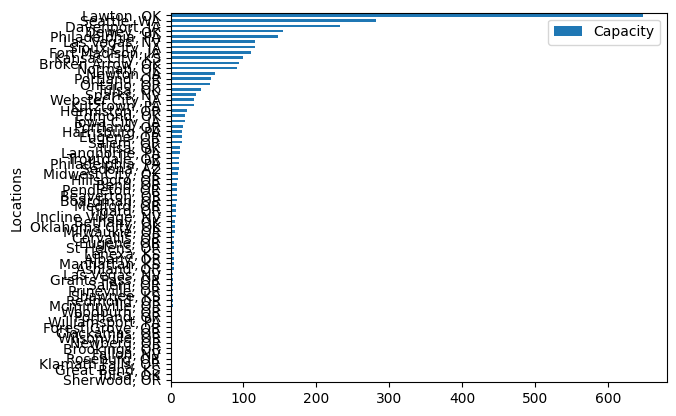

In [112]:
import matplotlib
shredder_to_oxide_producer = pd.read_excel(output_file_path, sheet_name='Shredder to oxide producer', usecols=[0,2])
shredder_capacities = shredder_to_oxide_producer.groupby('from').sum().reset_index(drop=False)
shredder_capacities["from"] = shredder_capacities["from"].map(lambda x: ", ".join(shredders[x]))
shredder_capacities.set_index('from', inplace=True)
shredder_capacities.index.name = "Locations"
shredder_capacities.rename({'Y1': 'Capacity'}, axis=1, inplace=True)
shredder_capacities.sort_values(by='Capacity').plot(kind='barh')

In [113]:
shredder_capacities.reset_index(drop=False, inplace=True)
add_sheet_to_excelbook(output_file_path, "Shredder Capacities", shredder_capacities)

<Axes: ylabel='Locations'>

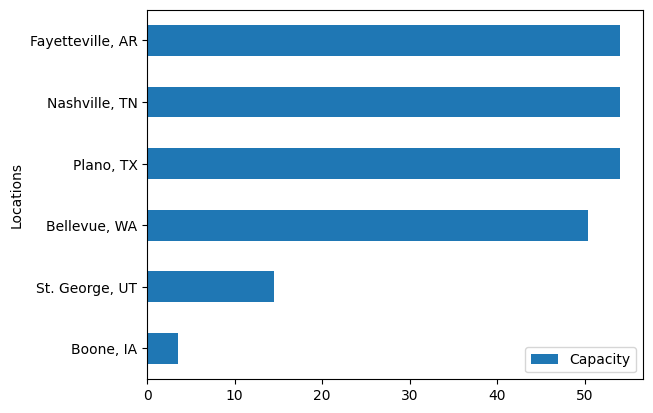

In [114]:
oxide_to_fluoride_producer = pd.read_excel(output_file_path, sheet_name='oxide to fluoride producer', usecols=[0,2])
oxide_capacities = oxide_to_fluoride_producer.groupby('from').sum().reset_index(drop=False)
oxide_capacities["from"] = oxide_capacities["from"].map(lambda x: ", ".join(oxide_producers[x]))
oxide_capacities.set_index('from', inplace=True)
oxide_capacities.index.name = "Locations"
oxide_capacities.rename({'Y1': 'Capacity'}, axis=1, inplace=True)
oxide_capacities.sort_values(by='Capacity').plot(kind='barh')

In [115]:
oxide_capacities.reset_index(drop=False, inplace=True)
add_sheet_to_excelbook(output_file_path, "Oxide Producer Capacities", oxide_capacities)

In [116]:
model_with_fixed_charge.remove(model_with_fixed_charge.getVars())
model_with_fixed_charge.remove(model_with_fixed_charge.getConstrs())

In [117]:
del flow_shredder_to_oxide_fixed_charge, flow_oxide_to_fluoride_fixed_charge, flow_fluoride_to_metal_fixed_charge, flow_waste_to_shredder_fixed_charge, flow_metal_to_magnet_fixed_charge, shredder_balance_fixed_charge, oxide_balance_fixed_charge, fluoride_balance_fixed_charge, metal_balance_fixed_charge
del waste_supply_limit_fixed_charge, shredder_supply_limit_fixed_charge, oxide_supply_limit_fixed_charge, fluoride_supply_limit_fixed_charge, metal_supply_limit_fixed_charge
del revenue_fixed_charge, conversion_cost_shredder_fixed_charge, conversion_cost_oxide_fixed_charge, conversion_cost_fluoride_fixed_charge, conversion_cost_metal_fixed_charge, 
del transportation_cost_shredder_fixed_charge, transportation_cost_oxide_fixed_charge, transportation_cost_fluoride_fixed_charge, transportation_cost_metal_fixed_charge, transportation_cost_waste_supplier_fixed_charge
del total_revenue_fixed_charge, total_conversion_cost_shredder_fixed_charge, total_conversion_cost_oxide_fixed_charge, total_conversion_cost_fluoride_fixed_charge, total_conversion_cost_metal
del total_transportation_cost_shredder_fixed_charge, total_transportation_cost_oxide_fixed_charge, total_transportation_cost_fluoride_fixed_charge, total_transportation_cost_metal_fixed_charge, total_transportation_cost_waste_supplier_fixed_charge
del obj_exprs_fixed_charge, model_with_fixed_charge

In [118]:
gc.collect()

139146